# Selecting a location for a well

Let's say you work for the mining company GlavRosGosNeft. We need to decide where to drill a new well.

You were provided with oil samples in three regions: in each 10,000 fields, where the quality of oil and the volume of its reserves were measured. Build a machine learning model that will help determine the region where mining will bring the greatest profit. Analyze the possible profits and risks using the *Bootstrap.* technique

Steps to select a location:

- Deposits are searched for in the selected region, and the characteristic values are determined for each;
- Build a model and estimate the volume of reserves;
- Deposits with the highest estimated values are selected. The number of fields depends on the company’s budget and the cost of developing one well;
- Profit is equal to the total profit of the selected fields.

## Loading and preparing data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
data_region0=pd.read_csv('datasets/geo_data_0.csv')
data_region1=pd.read_csv('datasets/geo_data_1.csv')
data_region2=pd.read_csv('datasets/geo_data_2.csv')
data_region0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [2]:
#check for duplicates

print(data_region0.drop_duplicates().shape)
print(data_region1.drop_duplicates().shape)
print(data_region2.drop_duplicates().shape)

(100000, 5)
(100000, 5)
(100000, 5)


In [3]:
#let's evaluate the possible correlation between the signs
print(data_region0.corr())
print(data_region1.corr())
print(data_region2.corr())

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_13503/3477714109.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data_region0.corr())
/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_13503/3477714109.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data_region1.corr())
/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_13503/3477714109.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data_region2.corr())


In [4]:
data_region0=data_region0.drop(['id'],axis=1).reset_index(drop=True)
data_region1=data_region1.drop(['id'],axis=1).reset_index(drop=True)
data_region2=data_region2.drop(['id'],axis=1).reset_index(drop=True)

There are no duplicates in the data, there is a moderate negative correlation between traits f0 and f1 in region 0, and a weak positive correlation between traits f0 and f1 in region 1. This could potentially bias the results for region 0.

## Model training and testing

In [5]:
#create a list of dataframes with data by region
regions=[data_region0,data_region1,data_region2]
#list where we will save the correct answers on the validation set
targets_valid=[]
#list where we will save predictions on the validation set
predictions=[]
#create a dictionary of lists for results
results = {'mean': [],'rmse': []}
#Train the model and get predictions for each region
for data in regions:
    target = data['product']
    features = data.drop('product', axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    # We will save the correct answers and predictions separately
    targets_valid.append(pd.Series(target_valid).reset_index(drop=True))
    predictions.append(pd.Series(predicted_valid).reset_index(drop=True))
    #let's calculate rmse and average   
    rmse=(mean_squared_error(target_valid, predicted_valid))**(1/2)
    mean=predicted_valid.mean()
    results['rmse'].append(rmse)    
    results['mean'].append(mean)
#let's check the results
print(results)
print(targets_valid)
print(predictions)

{'mean': [92.59256778438038, 68.728546895446, 94.96504596800492], 'rmse': [37.5794217150813, 0.8930992867756165, 40.02970873393434]}
[0         10.038645
1        114.551489
2        132.603635
3        169.072125
4        122.325180
            ...    
24995    170.116726
24996     93.632175
24997    127.352259
24998     99.782700
24999    177.821022
Name: product, Length: 25000, dtype: float64, 0         80.859783
1         53.906522
2         30.132364
3         53.906522
4          0.000000
            ...    
24995    137.945408
24996    110.992147
24997    137.945408
24998     84.038886
24999     53.906522
Name: product, Length: 25000, dtype: float64, 0         61.212375
1         41.850118
2         57.776581
3        100.053761
4        109.897122
            ...    
24995     28.492402
24996     21.431303
24997    125.487229
24998     99.422903
24999    127.445075
Name: product, Length: 25000, dtype: float64]
[0         95.894952
1         77.572583
2         77.892640
3      

In [6]:
#transform the results into DataFrame
predicted_res=pd.DataFrame(results)
print(predicted_res)

        mean       rmse
0  92.592568  37.579422
1  68.728547   0.893099
2  94.965046  40.029709


Models show that reserves in regions 0 and 2 are higher, but the prediction error is very high, which indicates a large scatter of values among wells. In region 1, reserves are smaller, but the spread of values is very small, which indicates the reliability of the model.

## Preparation for profit calculation

In [7]:
#save key values in separate variables
WELLS = 200
TEST_WELLS=500
BUDGET_TOTAL = 10E9
BUDGET_ONE_WELL = BUDGET_TOTAL/WELLS
PROFIT_BARREL = 450000
ALPHA = 0.025

In [8]:
well_min_barrel=BUDGET_ONE_WELL/PROFIT_BARREL
print(well_min_barrel)

111.11111111111111


Conclusion: sufficient supply of raw materials for break-even development of a new well - 111,111 barrels

## Calculation of profits and risks

In [9]:
#function for calculating profit

def revenue(target, predictions, count):
    predictions=predictions.reset_index(drop=True)
    target=target.reset_index(drop=True)
    preds_sorted = predictions.sort_values(ascending=False)
    selected = target[preds_sorted.index][:count]




    profit_total = selected*PROFIT_BARREL
    return profit_total.sum() - (BUDGET_ONE_WELL*count)

In [10]:
state = np.random.RandomState(12345)
#Let's create a dictionary for the results
stat={'mean':[],'25quantile':[],'loss_probability':[]}
values_for_plot=[]
#Let's use the Bootstrap technique with 1000 samples to find the profit distribution

for target,predictions in zip(targets_valid, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.sample(TEST_WELLS, replace=True, random_state=state)
        preds_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, preds_subsample, WELLS))   
    
    values = pd.Series(values)
    stat['mean'].append(values.mean())
    stat['25quantile'].append((values.quantile(ALPHA), values.quantile(1-ALPHA)))
    stat['loss_probability'].append(100*values[values < 0].count()/values.count())
    values_for_plot.append(values)
    #sns.distplot(values, label=count)
    #plt.legend(title="regions")
    

In [11]:
pd.DataFrame(stat)

,mean,25quantile,loss_probability
0,3.961650e+08,"(-111215545.89049521, 909766941.5534226)",6.9
1,4.611558e+08,"(78050810.75174175, 862952060.2637253)",0.7
2,3.929505e+08,"(-112227625.37857561, 934562914.5511655)",6.5


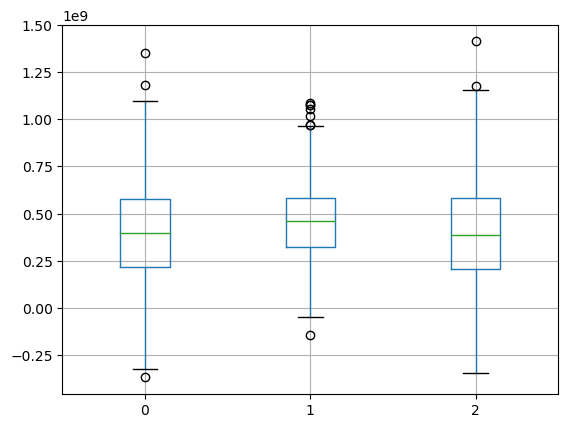

In [12]:
plot=pd.concat(values_for_plot,axis=1)
plot.boxplot();


Conclusion.
Region 1 is the most promising for development: it has the highest average profit, the probability of losses is only 0.7%, and the minimum value of the confidence interval for net profit in the 2.5% quartile is still above 0.